In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import random
from tqdm import tqdm

torch.manual_seed(0)
random.seed(0)
torch.use_deterministic_algorithms(True)
np.random.seed(0)
torch.random.seed = 0


def generate_synthetic_dataset(
    num_classes,
    num_dimensions,
    total_size,
    test_ratio,
    flip_y,
    random_seed=42
):
    """
    Generates a synthetic dataset with specified number of classes and dimensions.
    The dataset is split into training and testing sets.

    Parameters:
    - num_classes (int): Number of target classes.
    - num_dimensions (int): Number of features/dimensions.
    - total_size (int): Total number of samples.
    - test_ratio (float): Proportion of the dataset to use as the test set.
    - random_seed (int): Random seed for reproducibility.

    Returns:
    - X_train (np.ndarray): Training features.
    - X_test (np.ndarray): Testing features.
    - y_train (np.ndarray): Training labels.
    - y_test (np.ndarray): Testing labels.
    """
    np.random.seed(random_seed)

    # Ensure n_informative is compatible with the number of classes
    n_informative = max(int(np.ceil(np.log2(num_classes))), num_dimensions // 2)
    n_redundant = max(0, num_dimensions // 4)
    n_clusters_per_class = 1  # Ensure compatibility

    # Generate the full dataset
    X, y = make_classification(
        n_samples=total_size,
        n_features=num_dimensions,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=num_classes,
        n_clusters_per_class=n_clusters_per_class,
        random_state=random_seed,
        flip_y=flip_y
    )

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=random_seed
    )

    return X_train, X_test, y_train, y_test

def visualize_dataset_2d_3d(X, y, title="Dataset Visualization"):
    """
    Visualizes the dataset in 2D or 3D based on the number of features.

    Parameters:
    - X (np.ndarray): Features of the dataset.
    - y (np.ndarray): Labels of the dataset.
    - title (str): Title of the plot.
    """
    if X.shape[1] == 2:
        plt.figure(figsize=(8, 6))
        for class_label in np.unique(y):
            plt.scatter(X[y == class_label, 0], X[y == class_label, 1], label=f"Class {class_label}")
        plt.title(title)
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")
        plt.legend()
        plt.show()

    elif X.shape[1] == 3:
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        for class_label in np.unique(y):
            ax.scatter(X[y == class_label, 0], X[y == class_label, 1], X[y == class_label, 2], label=f"Class {class_label}")
        ax.set_title(title)
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")
        ax.set_zlabel("Feature 3")
        ax.legend()
        plt.show()



In [2]:
num_classes = 3
num_dimensions = 3
train_size = 1000
test_size = 500
random_seed = 123
flip_y = 0.10

X_train, X_test, y_train, y_test = generate_synthetic_dataset(
    num_classes, num_dimensions, train_size, test_size, flip_y, random_seed
)

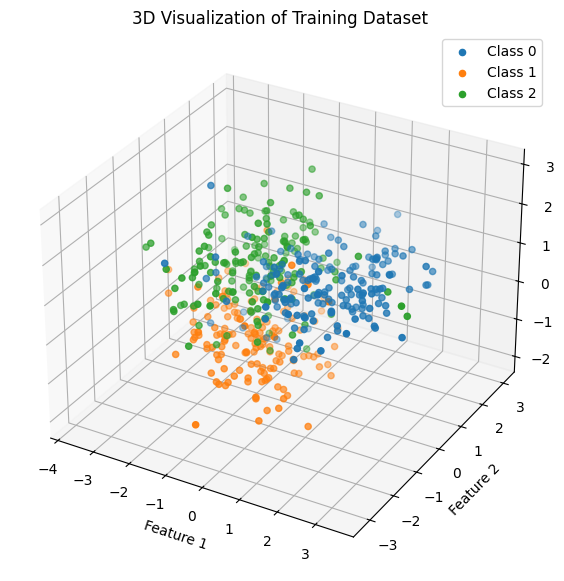

In [4]:
visualize_dataset_2d_3d(X_train,y_train, title="3D Visualization of Training Dataset")

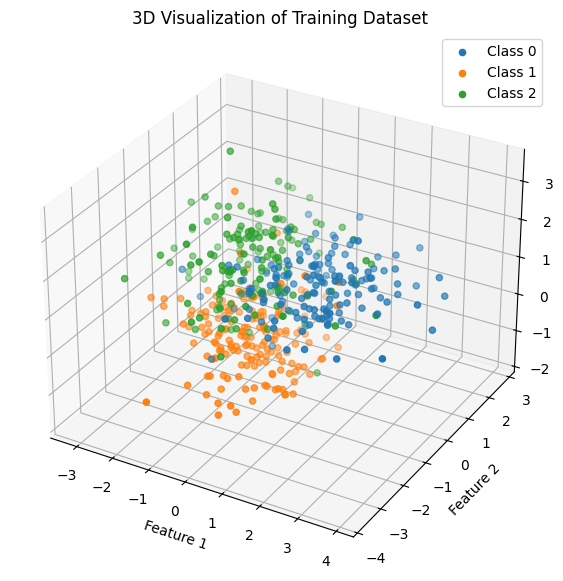

In [6]:
visualize_dataset_2d_3d(X_test,y_test, title="3D Visualization of Training Dataset")

In [7]:
def train_and_evaluate_mlp(X_train, X_test, y_train, y_test, input_dim, hidden_layers, model_name, epochs=50, batch_size=32, lr=0.001):
    """
    Train and evaluate an MLP model.
    """
    class MLP(nn.Module):
        def __init__(self, input_dim, hidden_layers, output_dim):
            super(MLP, self).__init__()
            layers = []
            current_dim = input_dim
            for hidden_dim in hidden_layers:
                layers.append(nn.Linear(current_dim, hidden_dim))
                layers.append(nn.ReLU())
                current_dim = hidden_dim
            layers.append(nn.Linear(current_dim, output_dim))
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        numpy.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)
    torch.manual_seed(0)
    random.seed(0)
    torch.use_deterministic_algorithms(True)
    np.random.seed(0)
    torch.random.seed = 0
    
    # DataLoader(
    #     train_dataset,
    #     batch_size=batch_size,
    #     num_workers=num_workers,
    #     worker_init_fn=seed_worker,
    #     generator=g,
    # )

    # Prepare data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=False,
                                               worker_init_fn=seed_worker,
                                               generator=g)

    # Model, loss, optimizer
    model = MLP(input_dim, hidden_layers, output_dim=len(set(y_train.numpy())))
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    train_loss_history = []
    test_loss_history = []
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        train_loss_history.append(loss.item())

        # Calculate test loss
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
            test_loss_history.append(test_loss)

    # Evaluation
    model.eval()
    torch.save(model.state_dict(), f'{model_name}.pth')
    
    with torch.no_grad():
        y_train_pred = model(X_train).argmax(axis=1).numpy()
        y_test_pred = model(X_test).argmax(axis=1).numpy()

    metrics = {
        "train_accuracy": accuracy_score(y_train.numpy(), y_train_pred),
        "train_precision": precision_score(y_train.numpy(), y_train_pred, average='weighted'),
        "train_recall": recall_score(y_train.numpy(), y_train_pred, average='weighted'),
        "test_accuracy": accuracy_score(y_test.numpy(), y_test_pred),
        "test_precision": precision_score(y_test.numpy(), y_test_pred, average='weighted'),
        "test_recall": recall_score(y_test.numpy(), y_test_pred, average='weighted'),
    }

    return model, y_train_pred, y_test_pred, metrics, train_loss_history, test_loss_history

In [13]:
overfitted_models = []
good_models = []

L_train_good = np.zeros((X_train.shape[0],3))
L_train_overfitted = np.zeros((X_train.shape[0],3))

L_dev_good = np.zeros((X_test.shape[0],3))
L_dev_overfitted = np.zeros((X_test.shape[0],3))

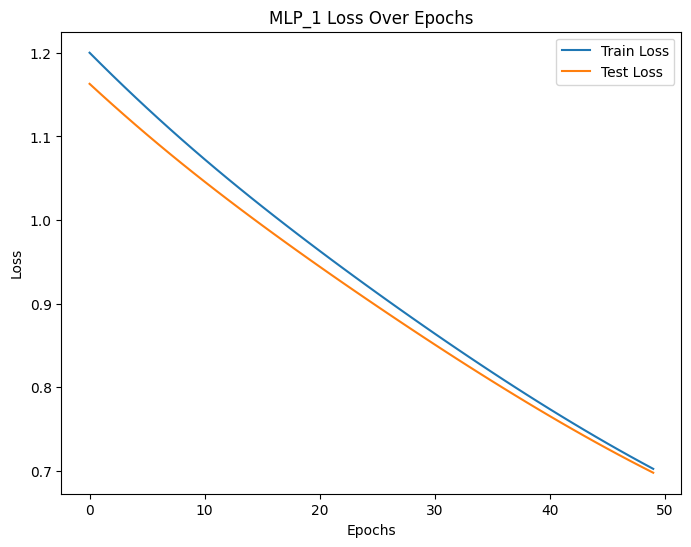

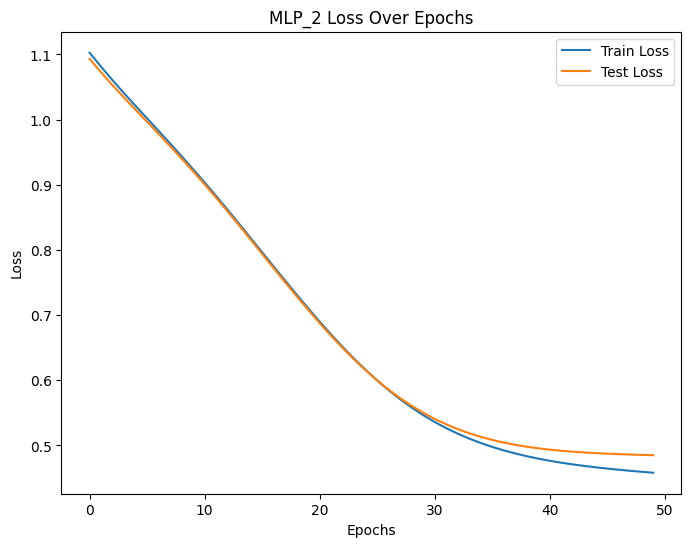

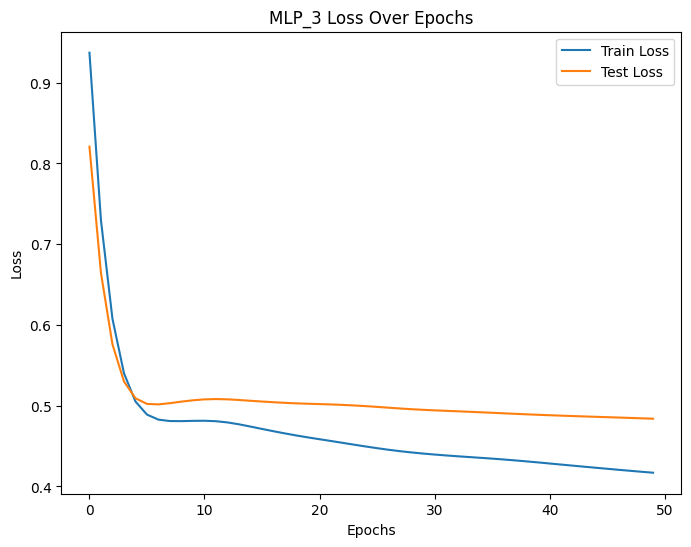

In [16]:




mlps = [
    {"hidden_layers": [32]},
    {"hidden_layers": [64, 32]},
    {"hidden_layers": [1024]},
]

results = []
for i, config in enumerate(mlps):
    model, pred_train_y, pred_test_y, metrics, train_loss_history, test_loss_history = train_and_evaluate_mlp(
        X_train, X_test, y_train, y_test,
        input_dim=num_dimensions,
        model_name=f'good_model_{i}',
        # model_name=f'overfitted_model_{i}',
        hidden_layers=config["hidden_layers"],
        epochs=50,
        batch_size=256,
        lr=0.001
    )
    L_train_good[:,i] = pred_train_y
    L_dev_good[:,i] = pred_test_y

    # L_train_overfitted[:,i] = pred_train_y
    # L_dev_overfitted[:,i] = pred_test_y
    
    good_models.append(model.eval())
    # overfitted_models.append(model.eval())
    
    results.append({"MLP": f"MLP_{i+1}", **metrics})

    # torch.save(model.state_dict(), f'good_model_{i}.pth')
    
    # torch.save(model.state_dict(), f'overfitted_model_{i}.pth')

    # Plot training and testing loss
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.title(f"MLP_{i+1} Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Convert results to DataFrame for better visualization
good_results_df = pd.DataFrame(results)
# overfitted_results_df = pd.DataFrame(results)
# print(results_df)

array([[2., 0., 2.],
       [2., 0., 0.],
       [0., 0., 0.],
       ...,
       [2., 2., 2.],
       [1., 1., 1.],
       [1., 1., 1.]])

Good models statistics:

In [17]:
good_results_df

,MLP,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,MLP_1,0.816,0.818183,0.816,0.802,0.802330,0.802
1,MLP_2,0.840,0.839917,0.840,0.844,0.843760,0.844
2,MLP_3,0.860,0.859289,0.860,0.846,0.844717,0.846


Bad models statistics:

In [15]:
overfitted_results_df

,MLP,train_accuracy,train_precision,train_recall,test_accuracy,test_precision,test_recall
0,MLP_1,0.888,0.88801,0.888,0.826,0.827755,0.826
1,MLP_2,1.000,1.00000,1.000,0.790,0.792082,0.790
2,MLP_3,1.000,1.00000,1.000,0.790,0.790563,0.790


# Snorkel 

In [18]:
from snorkel.labeling import labeling_function
import json
import os
import numpy as np
import imageio.v2 as imageio

In [19]:
@labeling_function()
def Overfitted_1(x):
    # x is a single example, so shape is [num_features]
    X = torch.tensor(x, dtype=torch.float32)  # shape [1, num_features]
    model = overfitted_models[0]
    model.load_state_dict(torch.load('overfitted_model_0.pth', weights_only=True))
    model.eval()
    with torch.no_grad():
        # model(X) is shape [1, num_classes]
        y_pred = model(X).argmax(dim=0).numpy()
    return y_pred


@labeling_function()
def Overfitted_2(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = overfitted_models[1]
    model.load_state_dict(torch.load('overfitted_model_1.pth', weights_only=True))
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).item()

    return y_train_pred


@labeling_function()
def Overfitted_3(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = overfitted_models[2]
    model.load_state_dict(torch.load('overfitted_model_2.pth', weights_only=True))
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred


@labeling_function()
def Good_Model_1(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = good_models[0]
    model.load_state_dict(torch.load('good_model_0.pth', weights_only=True))
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred


@labeling_function()
def Good_Model_2(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = good_models[1]
    model.load_state_dict(torch.load('good_model_1.pth', weights_only=True))
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred


@labeling_function()
def Good_Model_3(data):
    X = torch.tensor(data, dtype=torch.float32)
    model = good_models[2]
    model.load_state_dict(torch.load('good_model_2.pth', weights_only=True))
    model.eval()
    with torch.no_grad():
        y_train_pred = model(X).argmax(axis=0).numpy()

    return y_train_pred

In [20]:
from snorkel.labeling import LFApplier


# list_of_all_the_models = ['Overfitted_1', 'Overfitted_2', 'Overfitted_3', 'Good_Model_1', 'Good_Model_2', 'Good_Model_3']

lfs = [Overfitted_1, Overfitted_2, Overfitted_3, Good_Model_1, Good_Model_2, Good_Model_3]

# lfs = [Overfitted_1, Overfitted_2, Overfitted_3, Good_Model_1]

applier = LFApplier(lfs)

In [21]:
from snorkel.labeling import LFAnalysis

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

L_dev = applier.apply(X_test_scaled)
L_train = applier.apply(X_train_scaled)

500it [00:01, 471.93it/s]
500it [00:01, 488.09it/s]


In [22]:
# L_train = np.concatenate((L_train_overfitted, L_train_good), axis=1)
# L_dev = np.concatenate((L_dev_overfitted, L_dev_good), axis=1) 

In [23]:

LFAnalysis(L_dev, lfs).lf_summary(Y=y_test)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
Overfitted_1,0,"[0, 1, 2]",1.0,1.0,0.224,413,87,0.826
Overfitted_2,1,"[0, 1, 2]",1.0,1.0,0.224,395,105,0.790
Overfitted_3,2,"[0, 1, 2]",1.0,1.0,0.224,395,105,0.790
Good_Model_1,3,"[0, 1, 2]",1.0,1.0,0.224,401,99,0.802
Good_Model_2,4,"[0, 1, 2]",1.0,1.0,0.224,422,78,0.844
Good_Model_3,5,"[0, 1, 2]",1.0,1.0,0.224,423,77,0.846


In [24]:
LFAnalysis(L_train, lfs).lf_summary(Y=y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
Overfitted_1,0,"[0, 1, 2]",1.0,1.0,0.214,444,56,0.888
Overfitted_2,1,"[0, 1, 2]",1.0,1.0,0.214,500,0,1.000
Overfitted_3,2,"[0, 1, 2]",1.0,1.0,0.214,500,0,1.000
Good_Model_1,3,"[0, 1, 2]",1.0,1.0,0.214,408,92,0.816
Good_Model_2,4,"[0, 1, 2]",1.0,1.0,0.214,420,80,0.840
Good_Model_3,5,"[0, 1, 2]",1.0,1.0,0.214,430,70,0.860


In [47]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train[:,:4], n_epochs=5000, log_freq=500, seed=12)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4595.97epoch/s]
INFO:root:Finished Training


In [43]:
label_model.get_weights()

array([0.96140789, 0.92684816, 0.92684816, 0.92148213, 0.95520793,
       0.96704887])

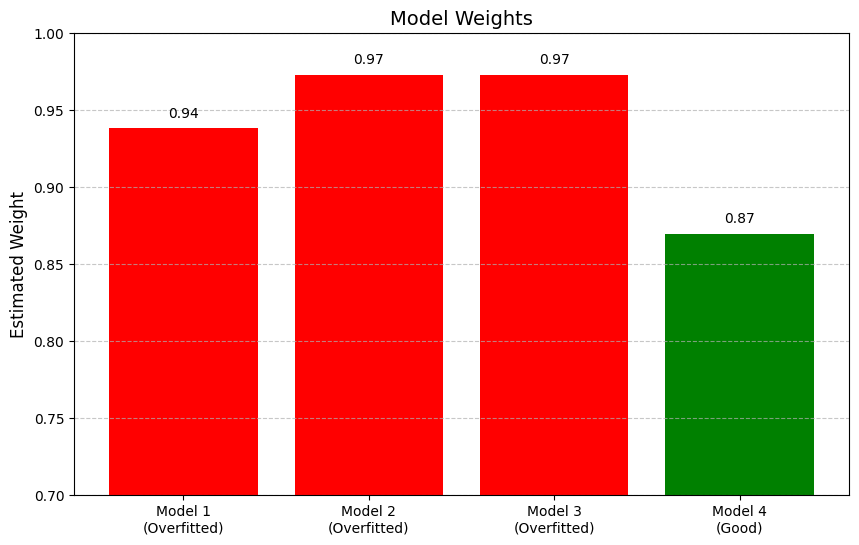

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Data
accuracies = label_model.get_weights()
# model_tags = ['Overfitted', 'Overfitted', 'Overfitted', 'Good', 'Good', 'Good']
# model_tags = ['Overfitted', 'Overfitted', 'Overfitted', 'Good', 'Good']
model_tags = ['Overfitted', 'Overfitted', 'Overfitted', 'Good']
model_labels = [f"Model {i+1}\n({tag})" for i, tag in enumerate(model_tags)]

# Visualization
plt.figure(figsize=(10, 6))
# bars = plt.bar(model_labels, accuracies, color=['red', 'red', 'red', 'green', 'green', 'green'])
# bars = plt.bar(model_labels, accuracies, color=['red', 'red', 'red', 'green', 'green'])
bars = plt.bar(model_labels, accuracies, color=['red', 'red', 'red', 'green'])

# Add values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{acc:.2f}", 
             ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title("Model Weights", fontsize=14)
plt.ylabel("Estimated Weight", fontsize=12)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.savefig('model_wights_normal_1.png')
plt.show()


# Adding Noise

In [31]:
noise_scaler = 0.5

train_variance = np.var(X_train_scaled, axis=0)  
test_variance = np.var(X_test_scaled, axis=0)

train_noise = np.random.normal(0, noise_scaler * np.sqrt(train_variance), X_train_scaled.shape)
test_noise = np.random.normal(0, noise_scaler * np.sqrt(test_variance), X_test_scaled.shape)


train_noisy_data = X_train_scaled + train_noise
test_noisy_data = X_test_scaled + test_noise

In [32]:
L_dev_noisy = applier.apply(test_noisy_data)
L_train_noisy = applier.apply(train_noisy_data)

500it [00:01, 441.41it/s]
500it [00:01, 484.62it/s]


In [33]:
LFAnalysis(L_dev_noisy, lfs).lf_summary(Y=y_test)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
Overfitted_1,0,"[0, 1, 2]",1.0,1.0,0.374,341,159,0.682
Overfitted_2,1,"[0, 1, 2]",1.0,1.0,0.374,320,180,0.640
Overfitted_3,2,"[0, 1, 2]",1.0,1.0,0.374,328,172,0.656
Good_Model_1,3,"[0, 1, 2]",1.0,1.0,0.374,372,128,0.744
Good_Model_2,4,"[0, 1, 2]",1.0,1.0,0.374,386,114,0.772
Good_Model_3,5,"[0, 1, 2]",1.0,1.0,0.374,383,117,0.766


In [34]:
LFAnalysis(L_train_noisy, lfs).lf_summary(Y=y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
Overfitted_1,0,"[0, 1, 2]",1.0,1.0,0.354,348,152,0.696
Overfitted_2,1,"[0, 1, 2]",1.0,1.0,0.354,334,166,0.668
Overfitted_3,2,"[0, 1, 2]",1.0,1.0,0.354,359,141,0.718
Good_Model_1,3,"[0, 1, 2]",1.0,1.0,0.354,381,119,0.762
Good_Model_2,4,"[0, 1, 2]",1.0,1.0,0.354,386,114,0.772
Good_Model_3,5,"[0, 1, 2]",1.0,1.0,0.354,394,106,0.788


In [55]:
label_model = LabelModel(cardinality=3, verbose=True)
label_model.fit(L_train_noisy[:,:6], n_epochs=5000, log_freq=500, seed=12)

INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4536.41epoch/s]
INFO:root:Finished Training


In [56]:
label_model.get_weights()

array([0.89531176, 0.86495527, 0.88069813, 0.90537614, 0.94582686,
       0.95788756])

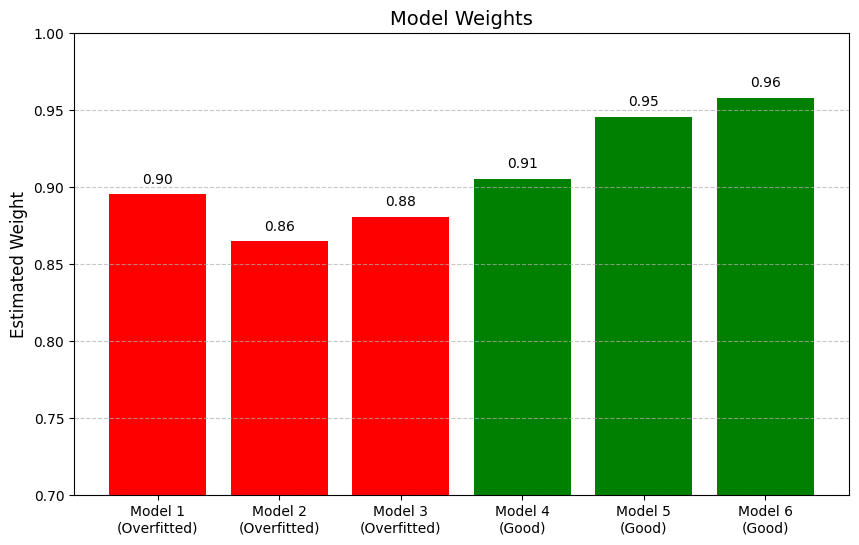

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Data
accuracies = label_model.get_weights()
model_tags = ['Overfitted', 'Overfitted', 'Overfitted', 'Good', 'Good', 'Good']
# model_tags = ['Overfitted', 'Overfitted', 'Overfitted', 'Good', 'Good']
# model_tags = ['Overfitted', 'Overfitted', 'Overfitted', 'Good']
model_labels = [f"Model {i+1}\n({tag})" for i, tag in enumerate(model_tags)]

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(model_labels, accuracies, color=['red', 'red', 'red', 'green', 'green', 'green'])
# bars = plt.bar(model_labels, accuracies, color=['red', 'red', 'red', 'green', 'green'])
# bars = plt.bar(model_labels, accuracies, color=['red', 'red', 'red', 'green'])

# Add values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f"{acc:.2f}", 
             ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title("Model Weights", fontsize=14)
plt.ylabel("Estimated Weight", fontsize=12)
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.savefig('model_wights_withnoise_3.png')
plt.show()
